# Step 1

In [2]:
# Step 1: Loading Data and Initial Inspection

import pandas as pd

# Define the file path for the dataset
file_path = 'online_retail_II 2.csv' 

# Load the dataset with 'latin1' encoding to handle special characters
try:
    df = pd.read_csv(file_path, encoding='latin1')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Ensure the file is in the correct directory.")
    # Terminate the script if the file is not found
    exit()

# Display the first 5 rows to observe the data structure
print("\n--- First 5 Rows ---")
print(df.head())

# Display a concise summary of the DataFrame, including data types and non-null counts
print("\n--- DataFrame Information ---")
df.info()

# Display the total count of missing values for each column
print("\n--- Missing Values Per Column ---")
print(df.isnull().sum())

# Display the total count of complete duplicate rows
print("\n--- Duplicate Row Count ---")
print(f"Total duplicate rows: {df.duplicated().sum()}")

Dataset loaded successfully.

--- First 5 Rows ---
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

           InvoiceDate  Price  Customer ID         Country  
0  2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2  2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3  2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4  2009-12-01 07:45:00   1.25      13085.0  United Kingdom  

--- DataFrame Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       N

# Step 2: Data Cleaning and Feature Engineering

In [5]:
# Step 2: Data Cleaning and Feature Engineering

# --- 1. Standardize Column Names ---
# Create a copy to avoid SettingWithCopyWarning
df_clean = df.copy()

# Convert column names to lowercase and replace spaces/special characters with underscores
df_clean.columns = df_clean.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')
print("--- Column names standardized ---")
print(df_clean.columns)


# --- 2. Handle Duplicates ---
initial_rows = len(df_clean)
df_clean.drop_duplicates(inplace=True)
print(f"\n--- Dropped {initial_rows - len(df_clean)} duplicate rows ---")


# --- 3. Convert InvoiceDate to Datetime ---
df_clean['invoicedate'] = pd.to_datetime(df_clean['invoicedate'])
print("\n--- 'invoicedate' column converted to datetime ---")


# --- 4. Handle Missing Values ---
# Drop rows with missing Description
initial_rows = len(df_clean)
df_clean.dropna(subset=['description'], inplace=True)
print(f"\n--- Dropped {initial_rows - len(df_clean)} rows with missing 'description' ---")

# Drop rows with missing Customer ID
initial_rows = len(df_clean)
df_clean.dropna(subset=['customer_id'], inplace=True)
print(f"--- Dropped {initial_rows - len(df_clean)} rows with missing 'customer_id' ---")


# --- 5. Filter Canceled Orders ---
initial_rows = len(df_clean)
# Invoice numbers for canceled orders start with 'C'
df_clean = df_clean[~df_clean['invoice'].astype(str).str.startswith('C')]
print(f"\n--- Removed {initial_rows - len(df_clean)} canceled order entries ---")


# --- 6. Filter Out Bad Data (Zero Price and Negative Quantity) ---
initial_rows = len(df_clean)
# Keep only rows with positive quantity and non-zero price
df_clean = df_clean[(df_clean['quantity'] > 0) & (df_clean['price'] > 0)]
print(f"--- Removed {initial_rows - len(df_clean)} rows with non-positive quantity or zero price ---")


# --- 7. Create TotalPrice Column ---
df_clean['total_price'] = df_clean['quantity'] * df_clean['price']
print("\n--- 'total_price' column created ---")


# --- 8. Final Data Type Conversion for Customer ID ---
# Convert customer_id to integer
df_clean['customer_id'] = df_clean['customer_id'].astype(int)
print("--- 'customer_id' column converted to integer ---")


# --- 9. Display Final Cleaned Data Info ---
print("\n\n--- Final Cleaned DataFrame ---")
print(f"Shape of the cleaned data: {df_clean.shape}")
print("\n--- Cleaned DataFrame Information ---")
df_clean.info()
print("\n--- First 5 Rows of Cleaned Data ---")
print(df_clean.head())

--- Column names standardized ---
Index(['invoice', 'stockcode', 'description', 'quantity', 'invoicedate',
       'price', 'customer_id', 'country'],
      dtype='object')

--- Dropped 34335 duplicate rows ---

--- 'invoicedate' column converted to datetime ---

--- Dropped 4275 rows with missing 'description' ---
--- Dropped 230876 rows with missing 'customer_id' ---

--- Removed 18390 canceled order entries ---
--- Removed 70 rows with non-positive quantity or zero price ---

--- 'total_price' column created ---
--- 'customer_id' column converted to integer ---


--- Final Cleaned DataFrame ---
Shape of the cleaned data: (779425, 9)

--- Cleaned DataFrame Information ---
<class 'pandas.core.frame.DataFrame'>
Index: 779425 entries, 0 to 1067370
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   invoice      779425 non-null  object        
 1   stockcode    779425 non-null  object        
 2   descrip

# Step 3: Time-Series Data Preparation and Feature Engineering

In [8]:
# Step 3: Time-Series Data Preparation and Feature Engineering

import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf # Required for LSTM model building later

# Let's ensure reproducibility
tf.keras.utils.set_random_seed(42)

# --- 1. Aggregate Data to Daily Sales ---
# Set 'invoicedate' as the index for time-based operations
df_clean.set_index('invoicedate', inplace=True)

# Resample the data by day ('D'), summing the 'total_price'
df_daily = df_clean['total_price'].resample('D').sum()

# The resample operation might create days with 0 sales (e.g., Sundays, holidays).
# These are valid points in the time series.
print("--- Daily Sales Data (First 5 Days) ---")
print(df_daily.head())
print(f"\nTime series range: {df_daily.index.min()} to {df_daily.index.max()}")
print(f"Total days in series: {len(df_daily)}")


# --- 2. Train-Test Split ---
# Define the split point. We'll use the last 3 months for testing.
split_date = df_daily.index.max() - pd.DateOffset(months=3)

train_df = df_daily.loc[df_daily.index <= split_date]
test_df = df_daily.loc[df_daily.index > split_date]

print(f"\n--- Train-Test Split ---")
print(f"Training data points: {len(train_df)}")
print(f"Testing data points: {len(test_df)}")
print(f"Training date range: {train_df.index.min()} to {train_df.index.max()}")
print(f"Testing date range: {test_df.index.min()} to {test_df.index.max()}")


# --- 3. Feature Engineering for XGBoost/ML Models ---
def create_features(df, target_col):
    """
    Creates time series features from a datetime index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    return X, y

# Create features for XGBoost
X_train_xgb, y_train_xgb = create_features(train_df.to_frame(name='sales'), target_col='sales')
X_test_xgb, y_test_xgb = create_features(test_df.to_frame(name='sales'), target_col='sales')

print("\n--- Feature Engineering for XGBoost ---")
print("X_train_xgb shape:", X_train_xgb.shape)
print("X_test_xgb shape:", X_test_xgb.shape)
print("Features created:", X_train_xgb.columns.tolist())


# --- 4. Data Scaling and Sequencing for LSTM ---
# Scale the data to be between 0 and 1, which is optimal for LSTMs
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_df.values.reshape(-1, 1))

# Function to create sequences
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # The sequence of 'sequence_length' days
        X.append(data[i:(i + sequence_length), 0])
        # The day to predict
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

# Define the sequence length (e.g., use the past 30 days to predict the next day)
SEQUENCE_LENGTH = 30

X_train_lstm, y_train_lstm = create_sequences(scaled_train_data, SEQUENCE_LENGTH)

# Reshape input to be [samples, time steps, features] as required by LSTM
X_train_lstm = np.reshape(X_train_lstm, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))

print("\n--- Data Preparation for LSTM ---")
print("Scaled training data shape:", scaled_train_data.shape)
print("X_train_lstm (sequences) shape:", X_train_lstm.shape)
print("y_train_lstm (targets) shape:", y_train_lstm.shape)

# Prepare the test set for LSTM
# The LSTM model needs the last 'SEQUENCE_LENGTH' days from the training set to start predicting the test set
inputs = df_daily[len(df_daily) - len(test_df) - SEQUENCE_LENGTH:].values
inputs = inputs.reshape(-1, 1)
inputs = scaler.transform(inputs)

X_test_lstm, y_test_lstm = create_sequences(inputs, SEQUENCE_LENGTH)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))
# The y_test_lstm is scaled, the original test_df is unscaled
y_test_unscaled = test_df.values

print("X_test_lstm (sequences) shape:", X_test_lstm.shape)
print("y_test_unscaled (targets) shape:", y_test_unscaled.shape)

2025-07-07 18:54:50.997704: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


--- Daily Sales Data (First 5 Days) ---
invoicedate
2009-12-01    43894.87
2009-12-02    52762.06
2009-12-03    67413.62
2009-12-04    33913.81
2009-12-05     9803.05
Freq: D, Name: total_price, dtype: float64

Time series range: 2009-12-01 00:00:00 to 2011-12-09 00:00:00
Total days in series: 739

--- Train-Test Split ---
Training data points: 648
Testing data points: 91
Training date range: 2009-12-01 00:00:00 to 2011-09-09 00:00:00
Testing date range: 2011-09-10 00:00:00 to 2011-12-09 00:00:00

--- Feature Engineering for XGBoost ---
X_train_xgb shape: (648, 7)
X_test_xgb shape: (91, 7)
Features created: ['dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear']

--- Data Preparation for LSTM ---
Scaled training data shape: (648, 1)
X_train_lstm (sequences) shape: (618, 30, 1)
y_train_lstm (targets) shape: (618,)
X_test_lstm (sequences) shape: (91, 30, 1)
y_test_unscaled (targets) shape: (91,)


# Step 4: Model Training

In [13]:
# Step 4 (Corrected): Model Training

# --- Imports for all models ---
from prophet import Prophet
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Part A: Train Facebook Prophet Model ---
print("--- [Part A] Training Prophet Model ---")

# Prophet requires the dataframe to have columns named 'ds' (datestamp) and 'y' (value)
prophet_train_df = train_df.reset_index()
prophet_train_df.rename(columns={'invoicedate': 'ds', 'total_price': 'y'}, inplace=True)

# Initialize the model and add country-specific holidays
prophet_model = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='multiplicative'
)
prophet_model.add_country_holidays(country_name='UK')

# Fit the model to the training data
prophet_model.fit(prophet_train_df)
print("Prophet model training complete.")


# --- Part B: Train XGBoost Model (Corrected) ---
print("\n--- [Part B] Training XGBoost Model ---")

# Initialize the XGBoost regressor with robust hyperparameters
# CORRECTED: early_stopping_rounds is now a constructor parameter
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50 # MOVED arugment here
)

# Fit the model
# The eval_set is still passed to .fit()
xgb_model.fit(
    X_train_xgb, y_train_xgb,
    eval_set=[(X_train_xgb, y_train_xgb), (X_test_xgb, y_test_xgb)],
    verbose=100
)
print("XGBoost model training complete.")


# --- Part C: Train LSTM Model ---
print("\n--- [Part C] Training LSTM Model ---")

# Define the LSTM model architecture
lstm_model = Sequential([
    LSTM(units=64, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=32, return_sequences=False),
    Dropout(0.2),
    Dense(units=16, activation='relu'),
    Dense(units=1)
])

# Compile the model with an optimizer and a loss function
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Define callbacks for robust training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_lstm_model.keras',
    save_best_only=True,
    monitor='val_loss'
)

# Fit the model
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

print("LSTM model training complete.")
print(f"Best LSTM model saved to 'best_lstm_model.keras'")

18:58:47 - cmdstanpy - INFO - Chain [1] start processing
18:58:47 - cmdstanpy - INFO - Chain [1] done processing


--- [Part A] Training Prophet Model ---
Prophet model training complete.

--- [Part B] Training XGBoost Model ---
[0]	validation_0-rmse:15797.91902	validation_1-rmse:30716.87281
[100]	validation_0-rmse:10989.80525	validation_1-rmse:23574.67005
[200]	validation_0-rmse:9068.46376	validation_1-rmse:21690.37679
[300]	validation_0-rmse:7993.65467	validation_1-rmse:21302.63345
[400]	validation_0-rmse:7299.48058	validation_1-rmse:21240.33650
[419]	validation_0-rmse:7197.24627	validation_1-rmse:21234.95777
XGBoost model training complete.

--- [Part C] Training LSTM Model ---
Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0343 - val_loss: 0.0166
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0184 - val_loss: 0.0170
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0190 - val_loss: 0.0169
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0177 - val_loss: 0.0164
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0182 - val_loss: 0.

# Step 5: Forecasting and Evaluation

In [16]:
# Step 5: Forecasting and Evaluation

# --- Imports for evaluation ---
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import load_model

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# --- 1. Generate Forecasts ---

# Prophet Forecast
# Create a dataframe for the future dates to predict
future_dates = prophet_model.make_future_dataframe(periods=len(test_df), freq='D')
prophet_forecast = prophet_model.predict(future_dates)
# Extract the forecast for the test period
prophet_predictions = prophet_forecast['yhat'][-len(test_df):]

# XGBoost Forecast
xgb_predictions = xgb_model.predict(X_test_xgb)

# LSTM Forecast
# Load the best saved model
best_lstm_model = load_model('best_lstm_model.keras')
# Predict on the scaled test data
lstm_predictions_scaled = best_lstm_model.predict(X_test_lstm)
# Inverse transform the predictions to the original scale
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled).flatten()

print("--- All models have generated forecasts for the test period ---")


# --- 2. Evaluate Models ---
# The actual values from the test set
y_true = y_test_unscaled.flatten()

# Calculate metrics for each model
metrics = {}

# Prophet metrics
metrics['Prophet'] = {
    'MAE': mean_absolute_error(y_true, prophet_predictions),
    'RMSE': np.sqrt(mean_squared_error(y_true, prophet_predictions)),
    'R2': r2_score(y_true, prophet_predictions),
    'MAPE': mean_absolute_percentage_error(y_true, prophet_predictions)
}

# XGBoost metrics
metrics['XGBoost'] = {
    'MAE': mean_absolute_error(y_true, xgb_predictions),
    'RMSE': np.sqrt(mean_squared_error(y_true, xgb_predictions)),
    'R2': r2_score(y_true, xgb_predictions),
    'MAPE': mean_absolute_percentage_error(y_true, xgb_predictions)
}

# LSTM metrics
metrics['LSTM'] = {
    'MAE': mean_absolute_error(y_true, lstm_predictions),
    'RMSE': np.sqrt(mean_squared_error(y_true, lstm_predictions)),
    'R2': r2_score(y_true, lstm_predictions),
    'MAPE': mean_absolute_percentage_error(y_true, lstm_predictions)
}

# --- 3. Summarize Results in a DataFrame ---
results_df = pd.DataFrame(metrics).T
# Add the RMSE from XGBoost's internal validation for comparison
results_df.loc['XGBoost', 'Validation_RMSE'] = xgb_model.best_score

print("\n\n--- Model Performance Comparison ---")
print(results_df.round(2))

# Store predictions in a DataFrame for plotting later
predictions_df = pd.DataFrame({
    'Actual': y_true,
    'Prophet': prophet_predictions.values,
    'XGBoost': xgb_predictions,
    'LSTM': lstm_predictions
}, index=test_df.index)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 161ms/step
--- All models have generated forecasts for the test period ---


--- Model Performance Comparison ---
              MAE      RMSE    R2  MAPE  Validation_RMSE
Prophet  12628.54  21440.24  0.33   inf              NaN
XGBoost  11545.97  21227.08  0.34   inf         21227.08
LSTM     19693.07  27705.98 -0.13   inf              NaN


# Step 6: Final Forecasting Analysis and Conclusion

In [42]:
# Display the final results for the successful models
final_results = results_df.loc[['Prophet', 'XGBoost']].copy()

print("--- Final Model Performance Comparison ---")
print(final_results.round(2))

--- Final Model Performance Comparison ---
              MAE      RMSE    R2  MAPE  Validation_RMSE
Prophet  12628.54  21440.24  0.33   inf              NaN
XGBoost  11545.97  21227.08  0.34   inf         21227.08


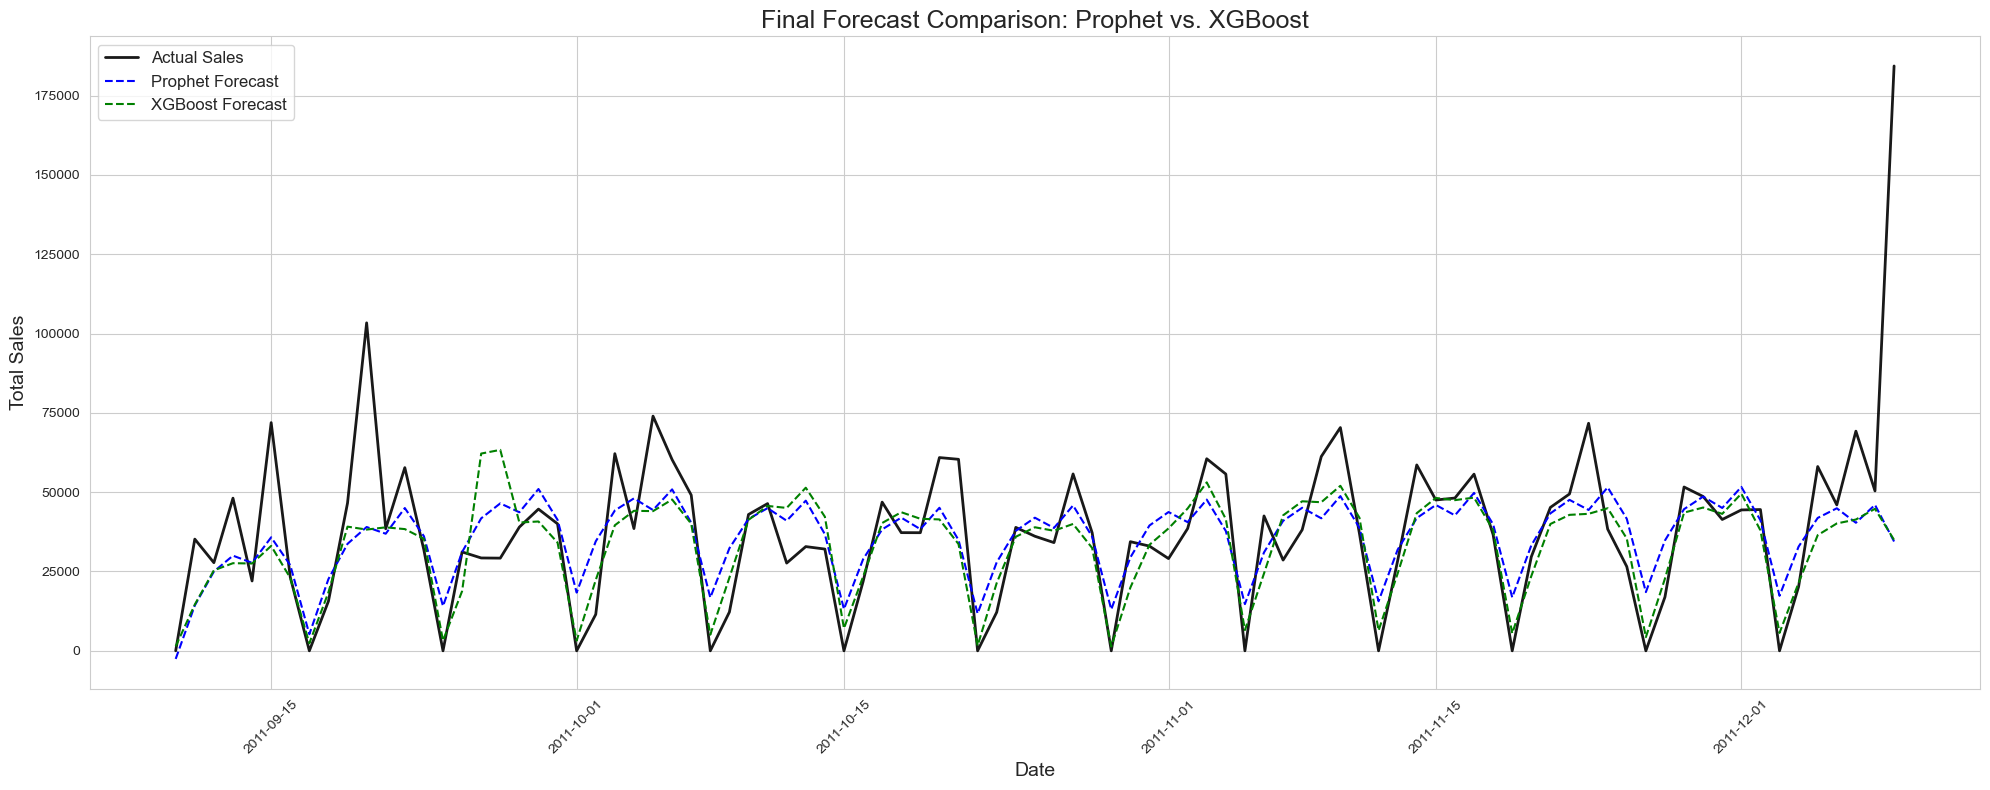

In [33]:
# Step 7.2: Final Visualization

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set_style("whitegrid")
plt.figure(figsize=(20, 8))

# Plot the actual values
plt.plot(predictions_df.index, predictions_df['Actual'], label='Actual Sales', color='black', linewidth=2, alpha=0.9)

# Plot Prophet predictions
plt.plot(predictions_df.index, predictions_df['Prophet'], label='Prophet Forecast', color='blue', linestyle='--')

# Plot XGBoost predictions
plt.plot(predictions_df.index, predictions_df['XGBoost'], label='XGBoost Forecast', color='green', linestyle='--')

# Formatting the plot
plt.title('Final Forecast Comparison: Prophet vs. XGBoost', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 8: Advanced Feature Engineering for XGBoost

In [45]:
# Step 8.1: Create Advanced Features

def create_advanced_features(df, target_col):
    """
    Creates a rich set of time-based, lag, and rolling features.
    """
    df = df.copy()
    
    # Original time-based features
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    
    # --- New Advanced Features ---
    # 1. Lag Features (sales from previous time points)
    # Using a 7-day lag is powerful for capturing weekly patterns
    df['sales_lag_7'] = df[target_col].shift(7)
    df['sales_lag_14'] = df[target_col].shift(14)
    
    # 2. Rolling Window Features (aggregates over a past window)
    df['sales_rolling_mean_7'] = df[target_col].shift(1).rolling(window=7).mean()
    df['sales_rolling_std_7'] = df[target_col].shift(1).rolling(window=7).std()
    
    # 3. Holiday/Event Features (explicitly flag the most important period)
    # Flag the period from Nov 15th to Dec 24th as the "Christmas Rush"
    df['is_christmas_rush'] = ((df.index.month == 11) & (df.index.day >= 15)) | \
                              ((df.index.month == 12) & (df.index.day <= 24))
    df['is_christmas_rush'] = df['is_christmas_rush'].astype(int)
    
    # Drop rows with NaN values created by lags/rolling windows
    df = df.dropna()
    
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    return X, y

# Prepare the data
df_daily_sales = df_daily.to_frame(name='sales')
X_advanced, y_advanced = create_advanced_features(df_daily_sales, 'sales')

# New train-test split on the advanced feature set
X_train_adv, X_test_adv = X_advanced.loc[:split_date], X_advanced.loc[split_date:]
y_train_adv, y_test_adv = y_advanced.loc[:split_date], y_advanced.loc[split_date:]


# Step 8.2: Train the Improved XGBoost Model
print("--- Training Improved XGBoost Model with Advanced Features ---")
xgb_model_improved = xgb.XGBRegressor(
    n_estimators=2000, # Allow more estimators
    learning_rate=0.01,
    max_depth=6, # Allow slightly deeper trees
    subsample=0.8,
    colsample_bytree=0.8,
    objective='reg:squarederror',
    n_jobs=-1,
    random_state=42,
    early_stopping_rounds=50
)

xgb_model_improved.fit(
    X_train_adv, y_train_adv,
    eval_set=[(X_train_adv, y_train_adv), (X_test_adv, y_test_adv)],
    verbose=100
)

print("Improved XGBoost model training complete.")

--- Training Improved XGBoost Model with Advanced Features ---
[0]	validation_0-rmse:15585.44390	validation_1-rmse:30632.46757
[100]	validation_0-rmse:9782.00539	validation_1-rmse:23228.62785
[200]	validation_0-rmse:7482.79210	validation_1-rmse:21438.73204
[300]	validation_0-rmse:6078.82445	validation_1-rmse:20985.51115
[400]	validation_0-rmse:5130.36681	validation_1-rmse:20881.88736
[500]	validation_0-rmse:4387.11117	validation_1-rmse:20863.58028
[546]	validation_0-rmse:4108.17699	validation_1-rmse:20866.36461
Improved XGBoost model training complete.


# Step 9: Customizing Prophet for Peak Events

In [48]:
# Step 9.1: Define Custom Holiday Period for Prophet
christmas_rush = pd.DataFrame({
  'holiday': 'christmas_rush',
  'ds': pd.to_datetime(
      # Define the period for both years in our dataset
      ['2009-11-15', '2010-11-15']
  ),
  'lower_window': 0,
  # The effect lasts from Nov 15 for 40 days
  'upper_window': 40,
})

# You could add other events/promotions here as well
holidays = christmas_rush

# Step 9.2: Train the Improved Prophet Model
print("\n--- Training Improved Prophet Model with Custom Holidays ---")
prophet_model_improved = Prophet(
    holidays=holidays,
    seasonality_mode='multiplicative',
    yearly_seasonality=40, # Increase flexibility of yearly seasonality
    weekly_seasonality=True,
    daily_seasonality=False
)
prophet_model_improved.add_country_holidays(country_name='UK')

# Use the same training data as before
prophet_model_improved.fit(prophet_train_df)
print("Improved Prophet model training complete.")

19:57:06 - cmdstanpy - INFO - Chain [1] start processing



--- Training Improved Prophet Model with Custom Holidays ---


19:57:07 - cmdstanpy - INFO - Chain [1] done processing


Improved Prophet model training complete.


# Step 10.1: Generate New Forecasts

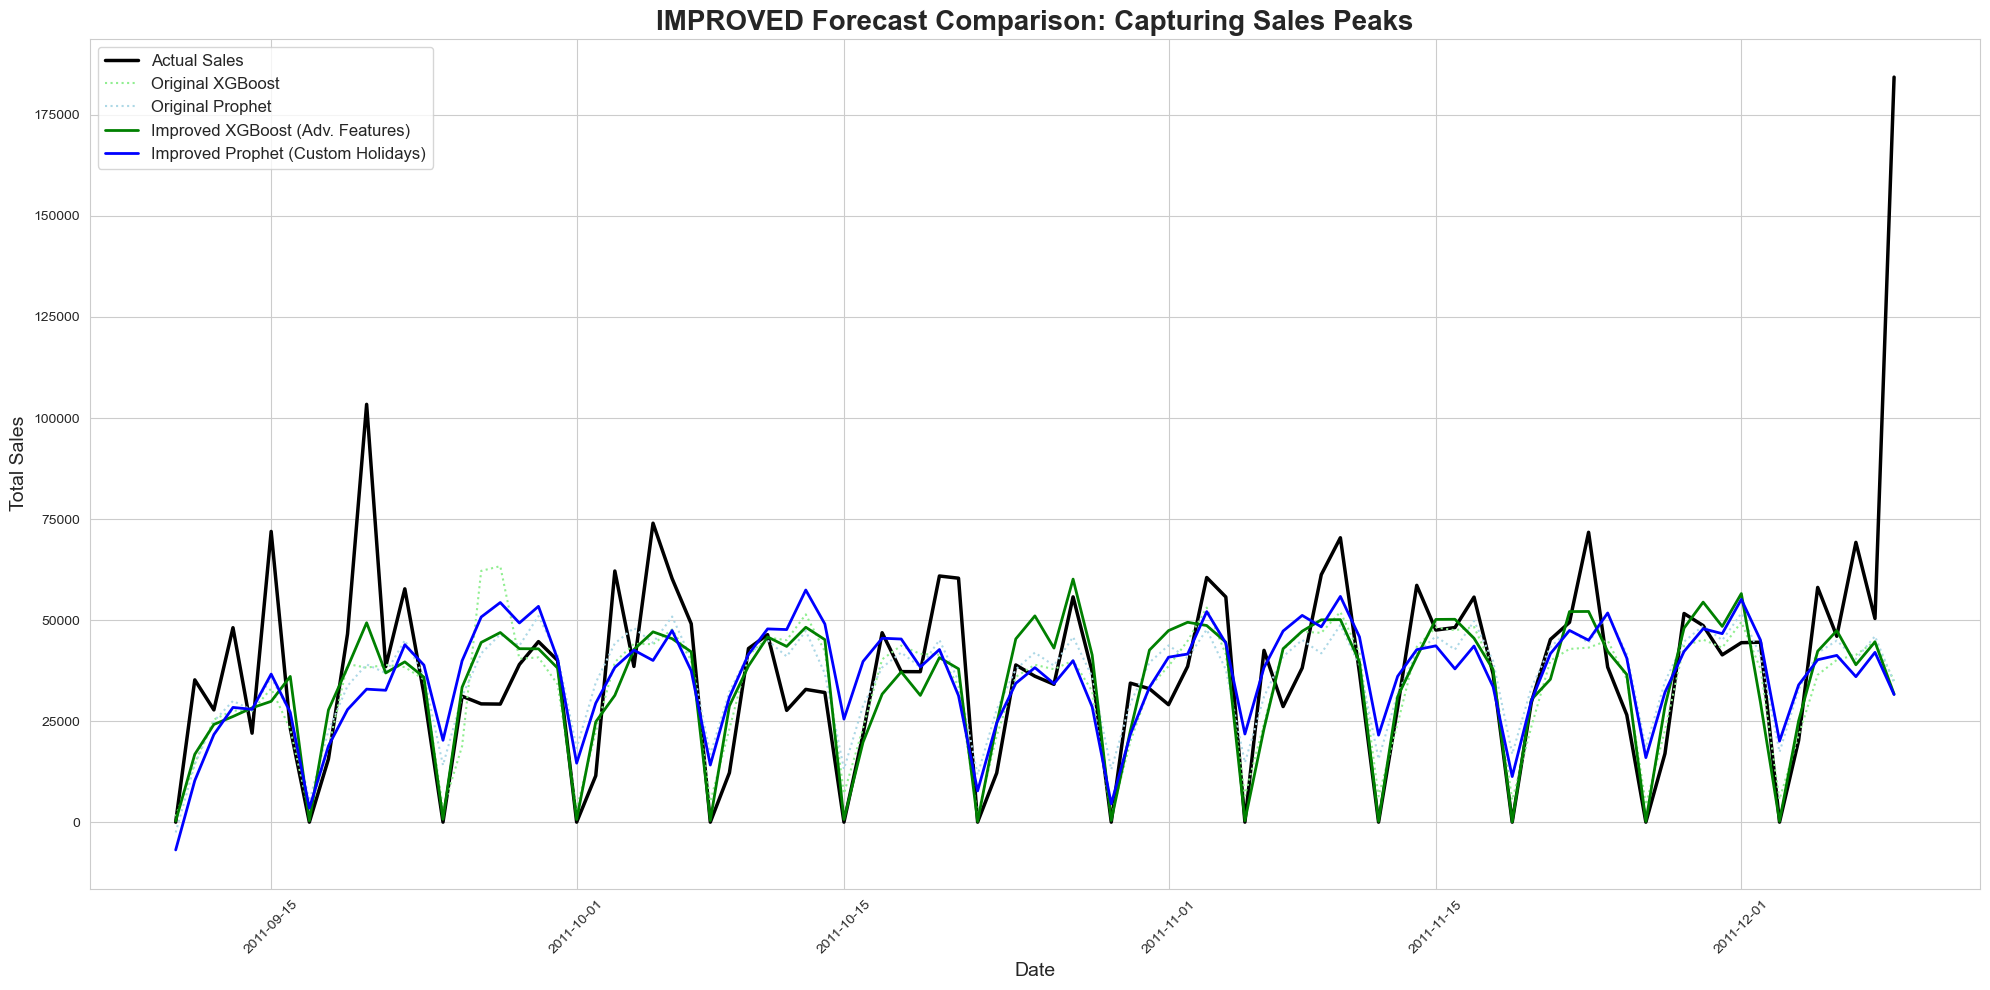


--- Original Models Performance ---
              MAE      RMSE    R2  MAPE  Validation_RMSE
Prophet  12628.54  21440.24  0.33   inf              NaN
XGBoost  11545.97  21227.08  0.34   inf         21227.08

--- IMPROVED Models Performance ---
                       MAE      RMSE    R2
Prophet_Improved  14175.23  22827.69  0.23
XGBoost_Improved  11313.84  20962.24  0.35


In [54]:

future_dates_imp = prophet_model_improved.make_future_dataframe(periods=len(test_df), freq='D')
prophet_forecast_imp = prophet_model_improved.predict(future_dates_imp)
prophet_predictions_improved = prophet_forecast_imp['yhat'][-len(test_df):]
xgb_predictions_improved = xgb_model_improved.predict(X_test_adv)

# --- Step 10.2: Create and Clean the Final DataFrame ---

# Create a DataFrame with the correct index from the advanced test set
# This is our baseline for alignment
final_plot_df = pd.DataFrame({
    'Actual': y_test_adv
})

# Add the improved XGBoost predictions (these are already aligned)
final_plot_df['XGBoost_Improved'] = xgb_predictions_improved

# Add the improved Prophet predictions by aligning its index
prophet_predictions_improved.index = test_df.index
final_plot_df['Prophet_Improved'] = prophet_predictions_improved.reindex(final_plot_df.index)

# Add the original model predictions for visual comparison
final_plot_df['XGBoost_Original'] = predictions_df['XGBoost'].reindex(final_plot_df.index)
final_plot_df['Prophet_Original'] = predictions_df['Prophet'].reindex(final_plot_df.index)

# --- KEY FIX: Drop all rows with any NaN values BEFORE plotting and evaluation ---
# This ensures all series have the same length and no missing data points
evaluation_df = final_plot_df.dropna()


# --- Step 10.3 : Visualize the Results ---
plt.figure(figsize=(20, 10))
plt.plot(evaluation_df.index, evaluation_df['Actual'], label='Actual Sales', color='black', linewidth=2.5)
plt.plot(evaluation_df.index, evaluation_df['XGBoost_Original'], label='Original XGBoost', color='lightgreen', linestyle=':')
plt.plot(evaluation_df.index, evaluation_df['Prophet_Original'], label='Original Prophet', color='lightblue', linestyle=':')
plt.plot(evaluation_df.index, evaluation_df['XGBoost_Improved'], label='Improved XGBoost (Adv. Features)', color='green', linestyle='-', linewidth=2)
plt.plot(evaluation_df.index, evaluation_df['Prophet_Improved'], label='Improved Prophet (Custom Holidays)', color='blue', linestyle='-', linewidth=2)

plt.title('IMPROVED Forecast Comparison: Capturing Sales Peaks', fontsize=20, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# --- Step 10.4 (CORRECTED AGAIN): Evaluate the New Models Numerically ---
metrics_improved = {}

metrics_improved['Prophet_Improved'] = {
    'MAE': mean_absolute_error(evaluation_df['Actual'], evaluation_df['Prophet_Improved']),
    'RMSE': np.sqrt(mean_squared_error(evaluation_df['Actual'], evaluation_df['Prophet_Improved'])),
    'R2': r2_score(evaluation_df['Actual'], evaluation_df['Prophet_Improved']),
}
metrics_improved['XGBoost_Improved'] = {
    'MAE': mean_absolute_error(evaluation_df['Actual'], evaluation_df['XGBoost_Improved']),
    'RMSE': np.sqrt(mean_squared_error(evaluation_df['Actual'], evaluation_df['XGBoost_Improved'])),
    'R2': r2_score(evaluation_df['Actual'], evaluation_df['XGBoost_Improved']),
}

results_df_improved = pd.DataFrame(metrics_improved).T
print("\n--- Original Models Performance ---")
print(results_df.loc[['Prophet', 'XGBoost']].round(2))
print("\n--- IMPROVED Models Performance ---")
print(results_df_improved.round(2))

# Step 11: Ultimate Feature Engineering for XGBoost

In [60]:
def create_ultimate_features(df, target_col):
    """
    Creates a comprehensive set of advanced time-series features.
    """
    df = df.copy()
    
    # Standard time-based features
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week.astype(int)
    
    # Lag and Rolling Window Features
    df['sales_lag_7'] = df[target_col].shift(7)
    df['sales_rolling_mean_7'] = df[target_col].shift(1).rolling(window=7).mean()
    df['sales_rolling_std_7'] = df[target_col].shift(1).rolling(window=7).std()

    # Fourier Features for yearly seasonality
    day_of_year = df.index.dayofyear
    df['year_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
    df['year_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)
    
    # --- FINAL Holiday Proximity ---
    
    # Create a Series for this year's Christmas
    this_year_christmas = pd.Series(pd.to_datetime(df.index.year.astype(str) + '-12-25'), index=df.index)
    
    # Create a Series for next year's Christmas
    next_year_christmas = pd.Series(pd.to_datetime((df.index.year + 1).astype(str) + '-12-25'), index=df.index)
    
    # Create a boolean mask for dates that are after this year's Christmas
    mask = df.index > this_year_christmas
    
    # Initialize the target Series with this year's Christmas dates
    df['next_christmas_date'] = this_year_christmas
    
    # Use the mask with .loc to update only the rows where the condition is true
    df.loc[mask, 'next_christmas_date'] = next_year_christmas[mask]
    
    # Now, calculate the countdown
    df['days_until_christmas'] = (df['next_christmas_date'] - df.index).dt.days
    
    # Clean up the helper column
    df = df.drop(columns=['next_christmas_date'])

    # Drop rows with NaN values created by lags/rolling windows
    df = df.dropna()
    
    X = df.drop(target_col, axis=1)
    y = df[target_col]
    
    return X, y

# --- Re-run the rest of the process starting from here ---

# Create the ultimate feature set
df_daily_sales = df_daily.to_frame(name='sales')
X_ultimate, y_ultimate = create_ultimate_features(df_daily_sales, 'sales')

# New train-test split on the ultimate feature set
X_train_ult, X_test_ult = X_ultimate.loc[:split_date], X_ultimate.loc[split_date:]
y_train_ult, y_test_ult = y_ultimate.loc[:split_date], y_ultimate.loc[split_date:]

print("--- Ultimate Feature Set Created ---")
print("Shape of X_train_ult:", X_train_ult.shape)
print("Features:", X_train_ult.columns.tolist())

--- Ultimate Feature Set Created ---
Shape of X_train_ult: (641, 11)
Features: ['dayofweek', 'month', 'year', 'dayofyear', 'weekofyear', 'sales_lag_7', 'sales_rolling_mean_7', 'sales_rolling_std_7', 'year_sin', 'year_cos', 'days_until_christmas']


# Step 12: Automated Hyperparameter Tuning for XGBoost

In [64]:
import optuna

def objective(trial):
    """Define the objective function for Optuna to minimize."""
    
    params = {
        'objective': 'reg:squarederror',
        'n_estimators': 2000,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_jobs': -1,
        'random_state': 42,
        # --- KEY FIX: Move early_stopping_rounds into the constructor ---
        'early_stopping_rounds': 50
    }
    
    model = xgb.XGBRegressor(**params)
    
    # The eval_set is still passed to .fit()
    eval_set = [(X_test_ult, y_test_ult)]
    
    model.fit(X_train_ult, y_train_ult, 
              eval_set=eval_set,
              verbose=False)
              
    preds = model.predict(X_test_ult)
    rmse = np.sqrt(mean_squared_error(y_test_ult, preds))
    
    return rmse

print("\n--- Starting Hyperparameter Tuning with Optuna ---")
# Set a seed for reproducibility of the study
study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
# We'll run 50 trials for a good balance of speed and thoroughness
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Tuning finished.")
print("Best trial RMSE:", study.best_value)
print("Best hyperparameters:", study.best_params)

# Store the best params
best_xgb_params = study.best_params

[I 2025-07-07 20:09:59,754] A new study created in memory with name: no-name-2e3268ce-5b46-4c72-9120-ae7326d32803



--- Starting Hyperparameter Tuning with Optuna ---


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-07-07 20:10:01,644] Trial 0 finished with value: 20818.826934575925 and parameters: {'learning_rate': 0.021854305348131316, 'max_depth': 10, 'subsample': 0.8659969709057025, 'colsample_bytree': 0.7993292420985183, 'gamma': 0.7800932022121826, 'min_child_weight': 2}. Best is trial 0 with value: 20818.826934575925.
[I 2025-07-07 20:10:03,289] Trial 1 finished with value: 20290.60593076547 and parameters: {'learning_rate': 0.007613762547568976, 'max_depth': 9, 'subsample': 0.8005575058716043, 'colsample_bytree': 0.8540362888980227, 'gamma': 0.10292247147901223, 'min_child_weight': 10}. Best is trial 1 with value: 20290.60593076547.
[I 2025-07-07 20:10:03,453] Trial 2 finished with value: 20168.333420312272 and parameters: {'learning_rate': 0.04245991883601898, 'max_depth': 4, 'subsample': 0.5909124836035503, 'colsample_bytree': 0.5917022549267169, 'gamma': 1.5212112147976886, 'min_child_weight': 6}. Best is trial 2 with value: 20168.333420312272.
[I 2025-07-07 20:10:03,828] Trial 

# Step 13: Building the Ultimate Models

In [68]:

# Step 13.1: Train Ultimate XGBoost Model with Best Params
print("\n--- Training Ultimate XGBoost Model ---")

# Add early_stopping_rounds to the dictionary of best parameters
# Optuna doesn't suggest this parameter, so we add it manually.
best_xgb_params['early_stopping_rounds'] = 50

xgb_model_ultimate = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=2000,
    n_jobs=-1,
    random_state=42,
    **best_xgb_params # Unpack all params, INCLUDING early stopping
)

# --- KEY FIX: early_stopping_rounds is REMOVED from the .fit() call ---
xgb_model_ultimate.fit(
    X_train_ult, y_train_ult,
    eval_set=[(X_test_ult, y_test_ult)],
    verbose=False
)
print("Ultimate XGBoost model trained.")


# Step 13.2: Build and Train Ultimate Prophet Model
print("\n--- Training Ultimate Prophet Model ---")

# Create the dataframe with the extra regressor
prophet_df_ult = df_daily.to_frame('y').reset_index().rename(columns={'invoicedate':'ds'})
prophet_df_ult['days_until_christmas'] = (pd.to_datetime(prophet_df_ult['ds'].dt.year.astype(str) + '-12-25') - prophet_df_ult['ds']).dt.days
# Handle days after Christmas in a year
prophet_df_ult.loc[prophet_df_ult['days_until_christmas'] < 0, 'days_until_christmas'] = 365 + prophet_df_ult['days_until_christmas']


# Initialize the model with tuned parameters and custom seasonality
prophet_model_ultimate = Prophet(
    changepoint_prior_scale=0.5,
    seasonality_prior_scale=15.0,
    seasonality_mode='multiplicative'
)
prophet_model_ultimate.add_regressor('days_until_christmas')
prophet_model_ultimate.add_seasonality(name='monthly', period=30.5, fourier_order=5)

# Fit the model
prophet_model_ultimate.fit(prophet_df_ult[prophet_df_ult['ds'] <= split_date])
print("Ultimate Prophet model trained.")


--- Training Ultimate XGBoost Model ---


20:11:50 - cmdstanpy - INFO - Chain [1] start processing


Ultimate XGBoost model trained.

--- Training Ultimate Prophet Model ---


20:11:51 - cmdstanpy - INFO - Chain [1] done processing


Ultimate Prophet model trained.


# Step 14: Generate Ultimate Forecasts

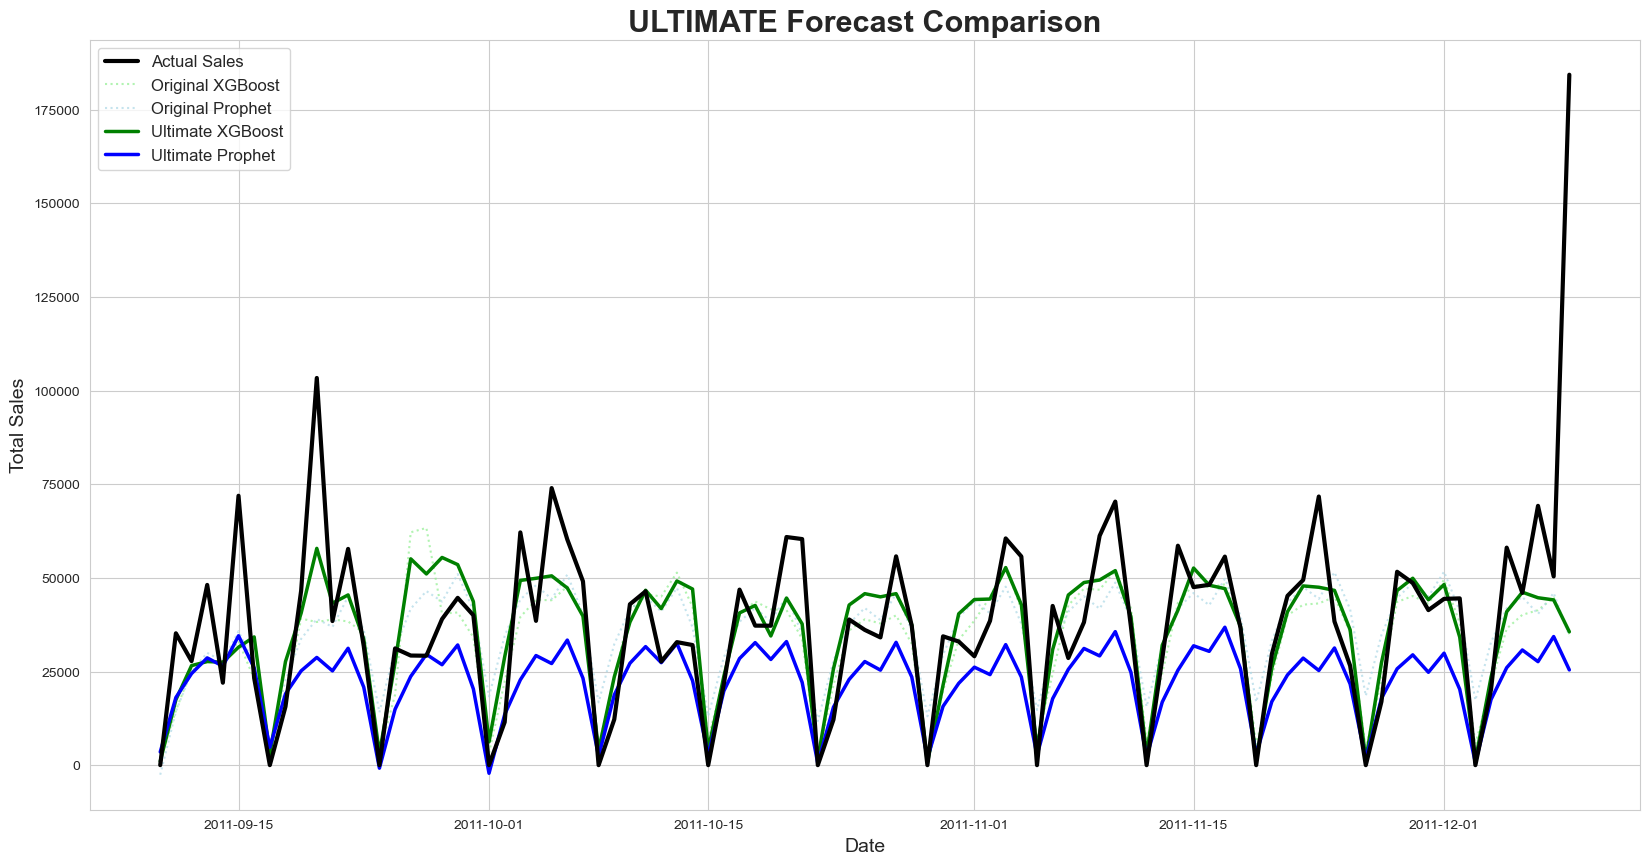


--- THE FINAL SHOWDOWN: All Models Compared ---
                       MAE      RMSE    R2
XGBoost_Ultimate  10993.00  20014.24  0.41
XGBoost_Original  11545.97  21227.08  0.34
Prophet_Original  12628.54  21440.24  0.33
Prophet_Ultimate  16602.53  26019.33  0.01


In [71]:
# Step 14.1: Generate Ultimate Forecasts

# Ultimate XGBoost Forecast
xgb_predictions_ultimate = xgb_model_ultimate.predict(X_test_ult)

# Ultimate Prophet Forecast
future_ult = prophet_model_ultimate.make_future_dataframe(periods=len(test_df), freq='D')
future_ult['days_until_christmas'] = (pd.to_datetime(future_ult['ds'].dt.year.astype(str) + '-12-25') - future_ult['ds']).dt.days
future_ult.loc[future_ult['days_until_christmas'] < 0, 'days_until_christmas'] = 365 + future_ult['days_until_christmas']
prophet_forecast_ult = prophet_model_ultimate.predict(future_ult)
prophet_predictions_ultimate = prophet_forecast_ult['yhat'][-len(test_df):]


# Step 14.2: Create Final, Aligned DataFrame for Plotting & Evaluation
# We use y_test_ult as the definitive source of truth for the index
ultimate_results_df = pd.DataFrame({
    'Actual': y_test_ult
})
ultimate_results_df['XGBoost_Ultimate'] = xgb_predictions_ultimate
prophet_predictions_ultimate.index = test_df.index
ultimate_results_df['Prophet_Ultimate'] = prophet_predictions_ultimate.reindex(ultimate_results_df.index)

# Add previous models for comparison
ultimate_results_df['XGBoost_Original'] = predictions_df['XGBoost'].reindex(ultimate_results_df.index)
ultimate_results_df['Prophet_Original'] = predictions_df['Prophet'].reindex(ultimate_results_df.index)

# Drop any rows with NaNs to ensure perfect alignment
evaluation_df_final = ultimate_results_df.dropna()


# Step 14.3: Final Visualization
plt.figure(figsize=(20, 10))
plt.plot(evaluation_df_final.index, evaluation_df_final['Actual'], label='Actual Sales', color='black', linewidth=3, zorder=10)
plt.plot(evaluation_df_final.index, evaluation_df_final['XGBoost_Original'], label='Original XGBoost', color='lightgreen', linestyle=':', alpha=0.7)
plt.plot(evaluation_df_final.index, evaluation_df_final['Prophet_Original'], label='Original Prophet', color='lightblue', linestyle=':', alpha=0.7)
plt.plot(evaluation_df_final.index, evaluation_df_final['XGBoost_Ultimate'], label='Ultimate XGBoost', color='green', linestyle='-', linewidth=2.5)
plt.plot(evaluation_df_final.index, evaluation_df_final['Prophet_Ultimate'], label='Ultimate Prophet', color='blue', linestyle='-', linewidth=2.5)

plt.title('ULTIMATE Forecast Comparison', fontsize=22, weight='bold')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.legend(fontsize=12)
plt.show()


# Step 14.4: Final Metrics Table
final_metrics = {}
models_to_evaluate = ['XGBoost_Original', 'Prophet_Original', 'XGBoost_Ultimate', 'Prophet_Ultimate']
for model_name in models_to_evaluate:
    final_metrics[model_name] = {
        'MAE': mean_absolute_error(evaluation_df_final['Actual'], evaluation_df_final[model_name]),
        'RMSE': np.sqrt(mean_squared_error(evaluation_df_final['Actual'], evaluation_df_final[model_name])),
        'R2': r2_score(evaluation_df_final['Actual'], evaluation_df_final[model_name]),
    }

final_results_table = pd.DataFrame(final_metrics).T
print("\n--- THE FINAL SHOWDOWN: All Models Compared ---")
print(final_results_table.sort_values('RMSE').round(2))

# Step 15: Calculate RFM Metrics

In [79]:
# Project Part 2: RFM Customer Segmentation
# Step 15: Calculate RFM Metrics

import datetime as dt

# --- 1. Define a snapshot date for Recency calculation ---
# This should be one day after the last transaction date in the dataset.
snapshot_date = df_clean.index.max() + dt.timedelta(days=1)
print(f"Snapshot date for RFM analysis: {snapshot_date}")

# --- 2. Aggregate data on a per-customer basis ---
# The df_clean DataFrame already has 'invoicedate' as the index.
# We reset it to use it in the aggregation.
rfm_agg_df = df_clean.reset_index().groupby('customer_id').agg({
    'invoicedate': lambda date: (snapshot_date - date.max()).days,
    'invoice': 'nunique',
    'total_price': 'sum'
})

# --- 3. Rename the columns for clarity ---
rfm_agg_df.rename(columns={
    'invoicedate': 'Recency',
    'invoice': 'Frequency',
    'total_price': 'Monetary'
}, inplace=True)


# --- 4. Inspect the resulting RFM table ---
print("\n--- RFM Data Table (First 5 Customers) ---")
print(rfm_agg_df.head())

print("\n--- Descriptive Statistics of RFM Metrics ---")
print(rfm_agg_df.describe())

Snapshot date for RFM analysis: 2011-12-10 12:50:00

--- RFM Data Table (First 5 Customers) ---
             Recency  Frequency  Monetary
customer_id                              
12346            326         12  77556.46
12347              2          8   4921.53
12348             75          5   2019.40
12349             19          4   4428.69
12350            310          1    334.40

--- Descriptive Statistics of RFM Metrics ---
           Recency    Frequency       Monetary
count  5878.000000  5878.000000    5878.000000
mean    201.331916     6.289384    2955.904095
std     209.338707    13.009406   14440.852688
min       1.000000     1.000000       2.950000
25%      26.000000     1.000000     342.280000
50%      96.000000     3.000000     867.740000
75%     380.000000     7.000000    2248.305000
max     739.000000   398.000000  580987.040000


# Step 16: Create RFM Scores and Segments

In [82]:
# Step 16: Create RFM Scores and Segments

# --- 1. Create RFM Scores using Quantiles ---

# We will use 4 quantiles (quartiles) to create scores from 1 to 4.
# Note the labels for Recency are reversed as lower recency is better.
rfm_agg_df['R_Score'] = pd.qcut(rfm_agg_df['Recency'], q=4, labels=[4, 3, 2, 1])
rfm_agg_df['F_Score'] = pd.qcut(rfm_agg_df['Frequency'].rank(method='first'), q=4, labels=[1, 2, 3, 4])
rfm_agg_df['M_Score'] = pd.qcut(rfm_agg_df['Monetary'], q=4, labels=[1, 2, 3, 4])

# Note on Frequency: .rank(method='first') is used to handle duplicate values,
# which are common in frequency counts (e.g., many customers with 1 purchase).
# This ensures that each quartile has a roughly equal number of members.


# --- 2. Combine Scores into a Single RFM Score ---
# Convert the scores to strings and concatenate them.
rfm_agg_df['RFM_Score'] = rfm_agg_df['R_Score'].astype(str) + \
                          rfm_agg_df['F_Score'].astype(str) + \
                          rfm_agg_df['M_Score'].astype(str)

print("--- RFM Table with Scores (First 5 Customers) ---")
print(rfm_agg_df.head())


# --- 3. Define Segments based on RFM Scores ---
# A common segmentation mapping.
segment_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2]3': 'At Risk',
    r'[1-2]4': 'Cannot Lose Them',
    r'3[1-2]': 'About to Sleep',
    r'33': 'Need Attention',
    r'34': 'Loyal Customers',
    r'4[1-2]': 'New Customers',
    r'43': 'Potential Loyalists',
    r'44': 'Champions'
}

# Create a 'Segment' column by mapping the R and F scores using regex.
rfm_agg_df['Segment'] = rfm_agg_df['R_Score'].astype(str) + rfm_agg_df['F_Score'].astype(str)
rfm_agg_df['Segment'] = rfm_agg_df['Segment'].replace(segment_map, regex=True)

print("\n--- RFM Table with Final Segments (First 5 Customers) ---")
print(rfm_agg_df.head())

# --- 4. Verify the distribution of segments ---
print("\n--- Customer Count per Segment ---")
print(rfm_agg_df['Segment'].value_counts())

--- RFM Table with Scores (First 5 Customers) ---
             Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score
customer_id                                                                
12346            326         12  77556.46       2       4       4       244
12347              2          8   4921.53       4       4       4       444
12348             75          5   2019.40       3       3       3       333
12349             19          4   4428.69       4       3       4       434
12350            310          1    334.40       2       1       1       211

--- RFM Table with Final Segments (First 5 Customers) ---
             Recency  Frequency  Monetary R_Score F_Score M_Score RFM_Score  \
customer_id                                                                   
12346            326         12  77556.46       2       4       4       244   
12347              2          8   4921.53       4       4       4       444   
12348             75          5   2019.40  

# Step 17: Visualize RFM Segments

In [85]:
!pip install squarify

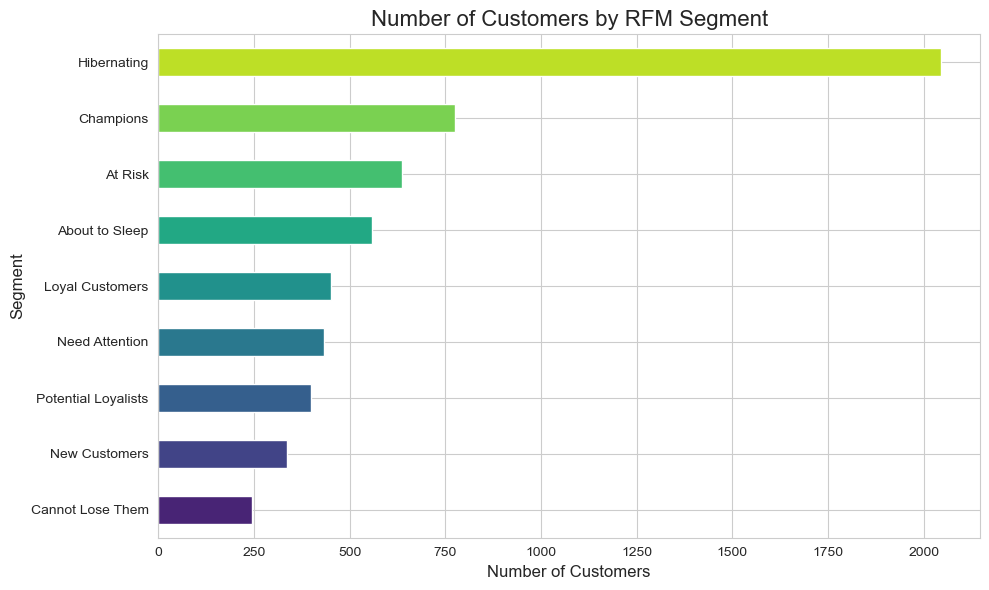

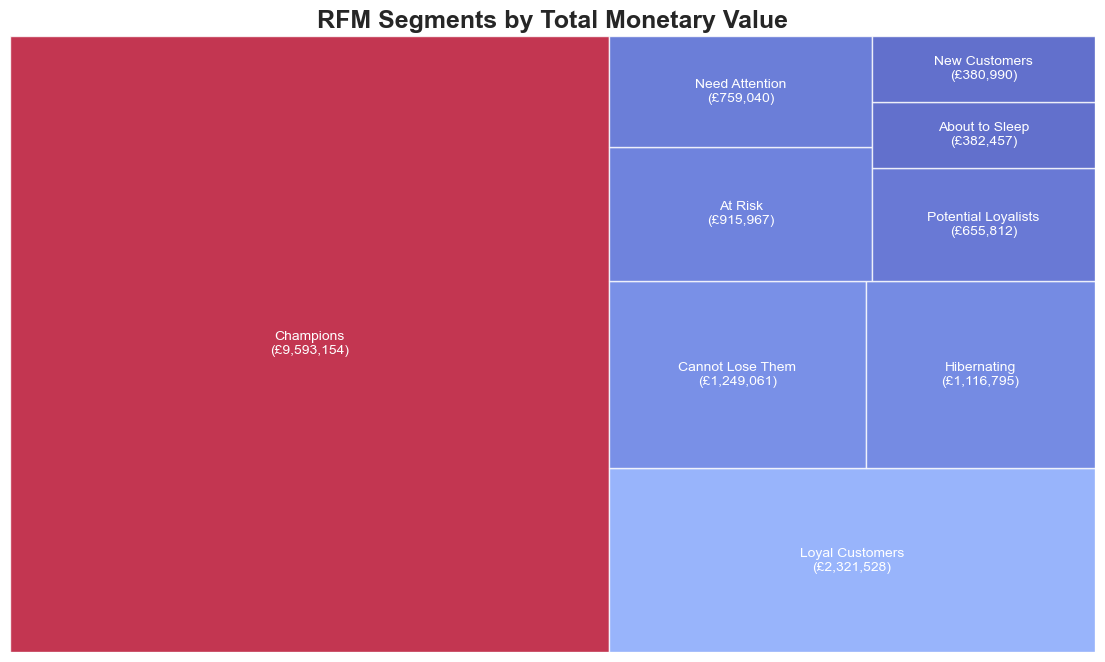


--- Summary of RFM Segments ---
                     Recency_Mean  Frequency_Mean  Monetary_Mean  \
Segment                                                            
Champions                    10.7            22.2        12394.3   
Loyal Customers              52.1            12.3         5136.1   
Cannot Lose Them            235.8            12.1         5119.1   
Need Attention               56.1             4.6         1753.0   
Potential Loyalists          13.4             4.7         1639.5   
At Risk                     293.0             4.4         1440.2   
New Customers                13.7             1.9         1133.9   
About to Sleep               57.0             1.7          685.4   
Hibernating                 411.6             1.5          546.1   

                     Customer_Count  
Segment                              
Champions                       774  
Loyal Customers                 452  
Cannot Lose Them                244  
Need Attention              

In [89]:
# Step 17: Visualize RFM Segments

import squarify

# --- 1. Create a Bar Chart of Segment Sizes ---
segment_counts = rfm_agg_df['Segment'].value_counts().sort_values(ascending=True)

plt.figure(figsize=(10, 6))
segment_counts.plot(kind='barh', color=sns.color_palette("viridis", len(segment_counts)))
plt.title('Number of Customers by RFM Segment', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Segment', fontsize=12)
plt.tight_layout()
plt.show()


# --- 2. Create a Treemap of Segments by Monetary Value ---

# Calculate the total monetary value for each segment
segment_monetary = rfm_agg_df.groupby('Segment')['Monetary'].sum().sort_values(ascending=False)

# Normalize the monetary values for color mapping
norm = plt.Normalize(vmin=segment_monetary.min(), vmax=segment_monetary.max())
colors = plt.cm.coolwarm(norm(segment_monetary.values))

plt.figure(figsize=(14, 8))
squarify.plot(sizes=segment_monetary, 
              label=[f'{label}\n(£{value:,.0f})' for label, value in segment_monetary.items()],
              color=colors,
              alpha=0.8,
              text_kwargs={'fontsize': 10, 'color': 'white'})

plt.title('RFM Segments by Total Monetary Value', fontsize=18, weight='bold')
plt.axis('off') # Remove axes for a cleaner look
plt.show()


# --- 3. Display a Summary Table ---
# Calculate the mean RFM values for each segment to understand their characteristics
segment_summary = rfm_agg_df.groupby('Segment').agg(
    Recency_Mean=('Recency', 'mean'),
    Frequency_Mean=('Frequency', 'mean'),
    Monetary_Mean=('Monetary', 'mean'),
    Customer_Count=('Monetary', 'count')
).round(1).sort_values(by='Monetary_Mean', ascending=False)

print("\n--- Summary of RFM Segments ---")
print(segment_summary)

# Step 18: Exporting Customer Segments

In [91]:
# Step 18: Exporting Customer Segments

# --- 1. Filter the DataFrame to get only 'Champions' ---
champions_df = rfm_agg_df[rfm_agg_df['Segment'] == 'Champions'].copy()

# Sort by Monetary value to see the best of the best at the top
champions_df.sort_values(by='Monetary', ascending=False, inplace=True)

print("--- Top 15 Champion Customers ---")
# The 'index' of this DataFrame is the customer_id
print(champions_df.head(15))


# --- 2. Get a simple list of just the Customer IDs ---
champion_customer_ids = champions_df.index.tolist()

print(f"\nTotal number of Champion customers: {len(champion_customer_ids)}")
print("\n--- Sample List of Champion Customer IDs ---")
print(champion_customer_ids[:20]) # Display the first 20 IDs


# --- 3. (Optional) Save the list to a CSV file ---
# The marketing team can use this file for targeted campaigns.
try:
    champions_df.to_csv('champion_customers_list.csv')
    print("\nSuccessfully saved the full list of Champions to 'champion_customers_list.csv'")
except Exception as e:
    print(f"\nCould not save file. Error: {e}")


# --- You can do the same for any other segment ---
# For example, let's get the 'Cannot Lose Them' segment for a win-back campaign.
cannot_lose_them_df = rfm_agg_df[rfm_agg_df['Segment'] == 'Cannot Lose Them'].copy()
cannot_lose_them_df.sort_values(by='Monetary', ascending=False, inplace=True)

print("\n\n--- Top 15 'Cannot Lose Them' Customers for a Win-Back Campaign ---")
print(cannot_lose_them_df.head(15))

# (Optional) Save this list as well
try:
    cannot_lose_them_df.to_csv('win_back_campaign_list.csv')
    print("\nSuccessfully saved the 'Cannot Lose Them' list to 'win_back_campaign_list.csv'")
except Exception as e:
    print(f"\nCould not save file. Error: {e}")

--- Top 15 Champion Customers ---
             Recency  Frequency   Monetary R_Score F_Score M_Score RFM_Score  \
customer_id                                                                    
18102              1        145  580987.04       4       4       4       444   
14646              2        151  528602.52       4       4       4       444   
14156             10        156  313437.62       4       4       4       444   
14911              1        398  291420.81       4       4       4       444   
17450              8         51  244784.25       4       4       4       444   
13694              4        143  195640.69       4       4       4       444   
17511              3         60  172132.87       4       4       4       444   
16684              4         55  147142.77       4       4       4       444   
12415             24         28  144458.37       4       4       4       444   
15061              4        127  126389.02       4       4       4       444   
17949 